Определить взаимосвязь между курсом доллара (USDRUB) и курсом нефти (BRENT).
Построить модели прогнозирования курса доллара разными методами анализа (регрессионный, нейронные сети, ... - 3-5 вариантов):
1. учитывая только курс доллара
2. учитывая курс BRENT
3. построить модель, основанную на пред. моделях, показавших наилучшие результаты, и проверить, что ошибка данной модели будет минимальной.

Курс нефти URALS был исключён из анализа, т.к. он основывается на котировках BRENT с коэффициентом 0.89.

In [11]:
import numpy as np
import pandas as pd
from scipy import stats
import itertools
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [12]:
def mean_approximation_error(y_real, y_pred):
    return np.abs((y_real - y_pred) / y_real).mean()

In [13]:
# загрузка данных котировок
data_Si = pd.read_csv('SPFB.Si_201201_211213.csv', encoding='cp1251', delimiter=';', parse_dates=['<DATE>'])
data_BR = pd.read_csv('SPFB.BR_201201_211213.csv', encoding='cp1251', delimiter=';', parse_dates=['<DATE>'])

quot_Si = data_Si['<CLOSE>']
quot_BR = data_BR['<CLOSE>']

In [14]:
# анализ взаимосвязи между курсами доллара и нефти

(np.cov(quot_Si, quot_BR), np.corrcoef(quot_Si, quot_BR))

(array([[ 1.91522051e+06, -7.04794919e+03],
        [-7.04794919e+03,  8.57830560e+01]]),
 array([[ 1.        , -0.54986062],
        [-0.54986062,  1.        ]]))

In [15]:
stats.spearmanr(quot_Si, quot_BR)

SpearmanrResult(correlation=-0.5927875223946102, pvalue=0.0)

In [16]:
stats.kendalltau(quot_Si, quot_BR)

KendalltauResult(correlation=-0.42655280099767545, pvalue=0.0)

Учитывая, что значения коэффицента корреляции Пирсона/Спирмена/Кенделла находятся в районе -0.5, можно заключить, что связь между двумя курсами противоположная и слабая, близко к средней. Из этого можно сделать, что добавление курса нефти для прогнозирования курса рубля к доллару не приведёт к улучшению результатов моделирования.

In [17]:
# инициализация параметров для линейной регрессии
factors = 16
future = 8

В качестве факторов, влияющих на будущие значения курса, будем брать предыдущие значения.

In [18]:
# подготовка данных для линейной регрессии
start = factors
end = len(quot_Si) - future
rawDF = []
rawDF_ext = []
for i in range(start, end):
    rawDF.append(list(quot_Si[(i - factors):(i + future)]))
    rawDF_ext.append(list(itertools.chain(list(quot_BR[(i - factors):i]), list(quot_Si[(i - factors):(i + future)]))))
    #rawDF_ext.append(list(itertools.chain(list(quot_BR[(i - factors):i]*1000), list(quot_Si[i:(i + future)]))))

In [19]:
# формируем данные для посторения моделей

factorCols = [f"factor_{i}" for i in range(factors)]
factorCols_ext = [f"factor_{i}" for i in range(2*factors)]
futureCols = [f"y_{i}" for i in range(future)]

DF = pd.DataFrame(rawDF, columns=(factorCols + futureCols))
DF_ext = pd.DataFrame(rawDF_ext, columns=(factorCols_ext + futureCols))

x = DF[factorCols][:-1].values
x_ext = DF_ext[factorCols_ext][:-1].values
y = DF[futureCols][:-1].values

# формируем данные для проверки моделирования (тестовые значения - последняя строка в датафрейме)

x_exam = DF[factorCols][-1:].values
x_exam_ext = DF_ext[factorCols_ext][-1:].values
y_exam = DF[futureCols][-1:].values[0]

In [20]:
# модель LinearRegression

from sklearn.linear_model import LinearRegression

LReg = LinearRegression()
LReg.fit(x, y) # обучение
y_pred = LReg.predict(x_exam)[0]
LReg.fit(x_ext, y) # обучение
y_pred_ext = LReg.predict(x_exam_ext)[0]

(y_exam, y_pred, y_pred_ext)

(array([74968., 74980., 74970., 74974., 74958., 74919., 74884., 74819.]),
 array([75024.66676867, 75044.06327452, 75047.65293038, 74995.20490001,
        74964.04540678, 74972.16094528, 74951.25762935, 74976.09680171]),
 array([75016.88579477, 75055.30816884, 75064.23899322, 75006.04184868,
        74974.5666619 , 74987.3070235 , 74980.92844399, 74996.33230584]))

In [21]:
# Коэффициент детерминации

R = (np.corrcoef(y_exam, y_pred) ** 2)[1,0]
R_ext = (np.corrcoef(y_exam, y_pred_ext) ** 2)[1,0]
(R, R_ext)

(0.37550673745343893, 0.24627872915104504)

In [22]:
# средняя ошибка аппроксимации

mae = mean_approximation_error(y_exam, y_pred)
mae_ext = mean_approximation_error(y_exam, y_pred_ext)

(mae, mae_ext)

(0.0008396224229108506, 0.0010172688281102295)

In [23]:
# Значения кванителей для оценки статистической значимости регрессии по F-критерию Фишера

k1 = factors
k1_ext = 2*k1
k2 = x.shape[0] - k1 - 1
k2_ext = x_ext.shape[0] - k1_ext - 1
alpha = 0.05

F_crit = stats.f.ppf(1 - alpha, k1, k2)
F_crit_ext = stats.f.ppf(1 - alpha, k1_ext, k2_ext)
(F_crit, F_crit_ext)

(1.645944351611502, 1.446390940016945)

In [24]:
T = (R / (1 - R)) * (k2 / k1)
T_ext = (R_ext / (1 - R_ext)) * (k2 / k1)
(T, T_ext)

(156.29997699058566, 84.93468293205265)

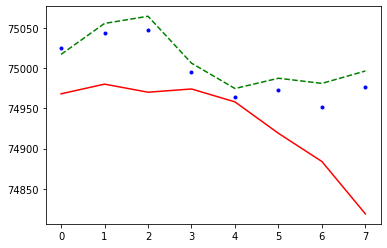

In [25]:
n = future
ox = range(n)
plt.plot(ox, y_exam, 'r')
plt.plot(ox, y_pred, 'b.')
plt.plot(ox, y_pred_ext, 'g--')

In [26]:
from sklearn.metrics import mean_absolute_error

# средняя абсолютная ошибка
(mean_absolute_error(np.array(list(y_exam)), np.array(y_pred)), 
 mean_absolute_error(np.array(list(y_exam)), np.array(y_pred_ext)))

(62.89358208871636, 76.20115509247444)

In [27]:
# модель MLP Regressor - neural net

from sklearn.neural_network import MLPRegressor

MLP = MLPRegressor(max_iter=5000, hidden_layer_sizes=20, beta_1=0.9, beta_2=0.95, random_state=42)
MLP.fit(x, y)
y_pred_NN = MLP.predict(x_exam)[0]
MLP.fit(x_ext, y)
y_pred_ext_NN = MLP.predict(x_exam_ext)[0]

(y_exam, y_pred_NN, y_pred_ext_NN)

(array([74968., 74980., 74970., 74974., 74958., 74919., 74884., 74819.]),
 array([74085.62604653, 74078.95831851, 74341.96560098, 74259.20936609,
        73937.95734463, 73846.85057887, 74213.91008427, 74050.61939862]),
 array([73919.13992744, 73850.48195473, 73389.44693077, 74029.32222079,
        73558.7706953 , 74483.2939198 , 73794.49856778, 73857.96427572]))

In [28]:
# Коэффициент детерминации

R = (np.corrcoef(y_exam, y_pred_NN) ** 2)[1,0]
R_ext = (np.corrcoef(y_exam, y_pred_ext_NN) ** 2)[1,0]
(R, R_ext)

(0.04229416839059104, 0.028052416263721968)

In [29]:
T = (R / (1 - R)) * (k2 / k1)
T_ext = (R_ext / (1 - R_ext)) * (k2 / k1)
(T, T_ext)

(11.479349956086505, 7.502333535848122)

In [30]:
mae_NN = mean_approximation_error(y_exam, y_pred_NN)
mae_ext_NN = mean_approximation_error(y_exam, y_pred_ext_NN)

(mae_NN, mae_ext_NN)

(0.011104411684819435, 0.014326763780919682)

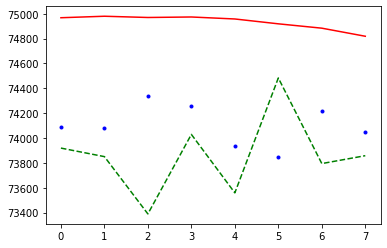

In [31]:
plt.plot(ox, y_exam, 'r')
plt.plot(ox, y_pred_NN, 'b.')
plt.plot(ox, y_pred_ext_NN, 'g--')

In [32]:
(mean_absolute_error(np.array(list(y_exam)), np.array(y_pred_NN)), 
 mean_absolute_error(np.array(list(y_exam)), np.array(y_pred_ext_NN)))

(832.1129076881589, 1073.635188460712)

In [33]:
# модель Lars

from sklearn.linear_model import Lars
 
Regression1 = Lars(n_nonzero_coefs=10)
Regression1.fit(x, y)
y_pred_Lars = Regression1.predict(x_exam)[0]
Regression1.fit(x_ext, y)
y_pred_ext_Lars = Regression1.predict(x_exam_ext)[0]

(y_exam, y_pred_Lars, y_pred_ext_Lars)

(array([74968., 74980., 74970., 74974., 74958., 74919., 74884., 74819.]),
 array([75047.68676454, 75046.84382029, 75043.78580212, 74998.591792  ,
        74988.20439163, 74975.11918538, 74968.59736548, 74978.58581556]),
 array([75051.12689509, 75045.70930232, 75030.53425598, 75006.31064036,
        74998.8990894 , 74991.90730711, 74965.88500407, 74975.03503372]))

In [34]:
# Коэффициент детерминации

R = (np.corrcoef(y_exam, y_pred_Lars) ** 2)[1,0]
R_ext = (np.corrcoef(y_exam, y_pred_ext_Lars) ** 2)[1,0]
(R, R_ext)

(0.4704666595635296, 0.6130064768069602)

In [35]:
T = (R / (1 - R)) * (k2 / k1)
T_ext = (R_ext / (1 - R_ext)) * (k2 / k1)
(T, T_ext)

(230.9428283014159, 411.74686788110836)

In [36]:
mae_Lars = mean_approximation_error(y_exam, y_pred_Lars)
mae_ext_lars = mean_approximation_error(y_exam, y_pred_ext_Lars)

(mae_Lars, mae_ext_lars)

(0.0009601659091307451, 0.0009901700466172195)

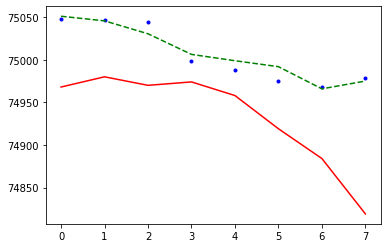

In [37]:
plt.plot(ox, y_exam, 'r')
plt.plot(ox, y_pred_Lars, 'b.')
plt.plot(ox, y_pred_ext_Lars, 'g--')

In [38]:
(mean_absolute_error(np.array(list(y_exam)), np.array(y_pred_Lars)), 
 mean_absolute_error(np.array(list(y_exam)), np.array(y_pred_ext_Lars)))

(71.926867124399, 74.17594100522365)

In [39]:
# модель Lasso

from sklearn.linear_model import Lasso
 
Regression2 = Lasso(alpha=0.001, max_iter=1000, tol=0.005)
Regression2.fit(x, y)
y_pred_Lasso = Regression2.predict(x_exam)[0]
Regression2.fit(x_ext, y)
y_pred_ext_Lasso = Regression2.predict(x_exam_ext)[0]

(y_exam, y_pred_Lasso, y_pred_ext_Lasso)

(array([74968., 74980., 74970., 74974., 74958., 74919., 74884., 74819.]),
 array([75210.17115805, 75048.18468612, 75052.06002782, 74999.24319742,
        74968.09334919, 74976.37694293, 74955.34384661, 74979.85286782]),
 array([75187.5872745 , 75069.08353156, 75082.18150496, 75031.56152179,
        75001.15853621, 75014.68965167, 75005.91925654, 75031.26847186]))

In [40]:
# Коэффициент детерминации

R = (np.corrcoef(y_exam, y_pred_Lasso) ** 2)[1,0]
R_ext = (np.corrcoef(y_exam, y_pred_ext_Lasso) ** 2)[1,0]
(R, R_ext)

(0.21304211022346367, 0.15604713409751356)

In [41]:
T = (R / (1 - R)) * (k2 / k1)
T_ext = (R_ext / (1 - R_ext)) * (k2 / k1)
(T, T_ext)

(70.36924624001998, 48.0625205011854)

In [42]:
mae_Lasso = mean_approximation_error(y_exam, y_pred_Lasso)
mae_ext_Lasso = mean_approximation_error(y_exam, y_pred_ext_Lasso)

(mae_Lasso, mae_ext_Lasso)

(0.0011967609355448554, 0.0015874368450665536)

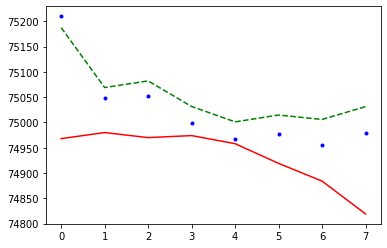

In [43]:
plt.plot(ox, y_exam, 'r')
plt.plot(ox, y_pred_Lasso, 'b.')
plt.plot(ox, y_pred_ext_Lasso, 'g--')

In [44]:
(mean_absolute_error(np.array(list(y_exam)), np.array(y_pred_Lasso)), 
 mean_absolute_error(np.array(list(y_exam)), np.array(y_pred_ext_Lasso)))

(89.66575949552134, 118.93121863764281)

In [45]:
# модель Nearst Neighbors Regressor

from sklearn.neighbors import KNeighborsRegressor

KNR = KNeighborsRegressor(n_neighbors=2)
KNR.fit(x, y)
y_pred_NNR = KNR.predict(x_exam)[0]
KNR.fit(x_ext, y)
y_pred_ext_NNR = KNR.predict(x_exam_ext)[0]

(y_exam, y_pred_NNR, y_pred_ext_NNR)

(array([74968., 74980., 74970., 74974., 74958., 74919., 74884., 74819.]),
 array([74926. , 74921. , 75015. , 74825.5, 74891. , 74863. , 74945.5,
        74873.5]),
 array([74926. , 74921. , 75015. , 74825.5, 74891. , 74863. , 74945.5,
        74873.5]))

In [46]:
# Коэффициент детерминации

R = (np.corrcoef(y_exam, y_pred_NNR) ** 2)[1,0]
R_ext = (np.corrcoef(y_exam, y_pred_ext_NNR) ** 2)[1,0]
(R, R_ext)

(0.03163995609428061, 0.03163995609428061)

In [47]:
T = (R / (1 - R)) * (k2 / k1)
T_ext = (R_ext / (1 - R_ext)) * (k2 / k1)
(T, T_ext)

(8.493133456937432, 8.493133456937432)

In [48]:
mae_NNR = mean_approximation_error(y_exam, y_pred_NNR)
mae_ext_NNR = mean_approximation_error(y_exam, y_pred_ext_NNR)

(mae_NNR, mae_ext_NNR)

(0.0008898806147427909, 0.0008898806147427909)

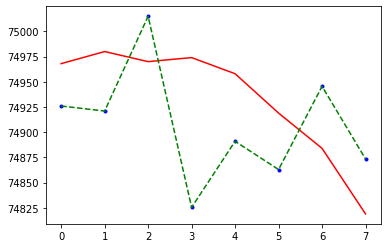

In [49]:
plt.plot(ox, y_exam, 'r')
plt.plot(ox, y_pred_NNR, 'b.')
plt.plot(ox, y_pred_ext_NNR, 'g--')

In [50]:
(mean_absolute_error(np.array(list(y_exam)), np.array(y_pred_NNR)), 
 mean_absolute_error(np.array(list(y_exam)), np.array(y_pred_ext_NNR)))

(66.6875, 66.6875)

In [51]:
# формируем прогнозный массив, взвешенный по наилучшим результатам
# (исключаем модель нейронной сети и не берём результаты, включающие курс нефти)

mae_sum = mae + mae_Lars + mae_Lasso + mae_NNR
y_pred_weighed = (mae/mae_sum)*y_pred + (mae_Lars/mae_sum)*y_pred_Lars + (mae_Lasso/mae_sum)*y_pred_Lasso + (mae_NNR/mae_sum)*y_pred_NNR

(y_exam, y_pred_weighed)

(array([74968., 74980., 74970., 74974., 74958., 74919., 74884., 74819.]),
 array([75064.88511348, 75017.84139588, 75040.57804334, 74958.42763906,
        74954.53522916, 74949.19532665, 74955.48146625, 74954.3766297 ]))

In [52]:
(mean_approximation_error(y_exam, y_pred_weighed), min(mae, mae_Lars, mae_Lasso, mae_NNR))

(0.0007699216917263203, 0.0008396224229108506)

Из результата видно, что ошибка общего прогноза минимальна.

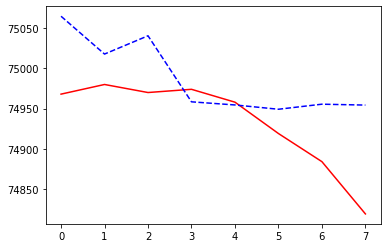

In [53]:
plt.plot(ox, y_exam, 'r')
plt.plot(ox, y_pred_weighed, 'b--')

In [54]:
mean_absolute_error(np.array(list(y_exam)), np.array(y_pred_weighed))

57.67438838463568